<a href="https://colab.research.google.com/github/bingsen-wang/EE-Fundamentals/blob/main/MagneticCircuit_IdealTransformer_RLCLoads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Ideal Transformer with Resistive, Inductive or Capacitive Load</h1></b>

Dr. Bingsen Wang

4/21/2024
</center>

#Python Code
The Python code illustrates an ideal tranformer.

<ipython-input-20-4e7970975cb8>:303: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


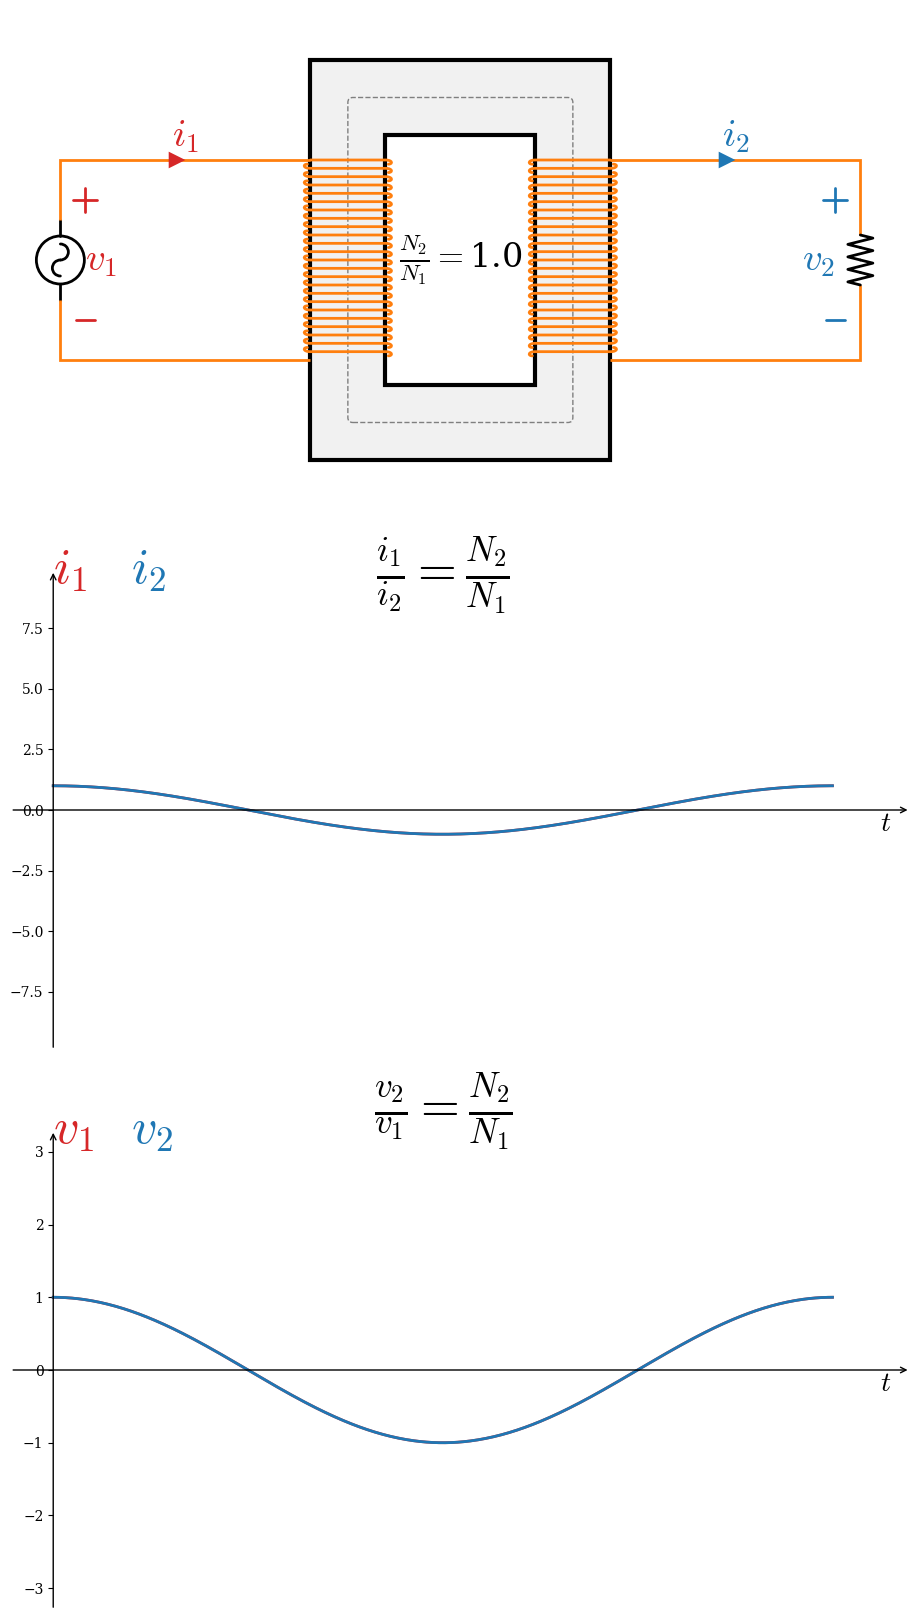

In [20]:
import matplotlib
from os import linesep
from math import ceil
import numpy as np
from numpy import linspace,cos,sin,pi,heaviside,array,sqrt,angle,exp,sign
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba#,TABLEAU_COLORS
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#modulation functions
def mf(t,f,phi):
  mta = cos(2*pi*f*t+phi)
  mtb = cos(2*pi*f*t+phi-2*pi/3)
  mtc = cos(2*pi*f*t+phi+2*pi/3)
  return [mta,mtb,mtc]

#switching functions for the high-side diodes
def hh(t,f,phi):
  ht = []
  for k in range(3):
    ht.append(heaviside(mf(t,f,phi)[k]-mf(t,f,phi)[(k+1)%3],0)*heaviside(mf(t,f,phi)[k]-mf(t,f,phi)[(k+2)%3],0))
  return ht

#switching functions for the low-side diodes
def hl(t,f,phi):
  ht = []
  for k in range(3):
    ht.append(heaviside(-mf(t,f,phi)[k]+mf(t,f,phi)[(k+1)%3],0)*heaviside(-mf(t,f,phi)[k]+mf(t,f,phi)[(k+2)%3],0))
  return ht

#ac current
def iac(t,f,phi):
  i = [] #high side current
  for k in range(3):
    i.append(hh(t,f,phi)[k] - hl(t,f,phi)[k])
  return i

#draw resistor symbol
def drawResistor(ax,x0,y0,n,h,theta,lw,color):
  """ n: number of zig-zags; h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  w= h/n#width of larger coil
  ps=[] # container of the zig-zags
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO]
  for k in range(n):
    p = Path([(x0 + k*w,y0),(x0 + (k+0.25)*w,y0+0.25*h),
              (x0+(0.75+k)*w,y0-0.25*h),(x0+(k+1)*w,y0)],codes)
    ps.append(mp.PathPatch(p))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw inductor symbol
def drawInductor(ax,x0,y0,n,h,w,theta,lw,color):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  w= w/(0.7*n+0.3)#width of larger coil
  plg, psm = ([],[]) #the half coil with larger curvature
  codes=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0,y0+0.4*h),(x0+w,y0+0.4*h),(x0+w,y0)]
  for k in range(n):
    if k==0:
      plg.append(mp.PathPatch(Path(verts,codes)))
    else:
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0+0.4*h),
                (x0+(0.7*k+1)*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0)], codes)
      plg.append(mp.PathPatch(p))
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0-0.2*h),
                (x0+(0.7*k+0.3)*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0)], codes)
      psm.append(mp.PathPatch(p))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw capcitor symbol
def drawCapacitor(ax,x0,y0,h,theta,lw,color):
  """ h: height or width;   lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  dx1,dx2,dy = (0.425*h, 0.575*h, 0.25*h)
  p = Path([(x0,y0),(x0+dx1,y0),(x0+dx1,y0+dy),(x0+dx1,y0-dy),
            (x0+dx2,y0+dy),(x0+dx2,y0-dy),(x0+dx2,y0),(x0+h,y0)],
           [Path.MOVETO,Path.LINETO, Path.MOVETO,Path.LINETO,
            Path.MOVETO, Path.LINETO,Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  args = dict({'lw':lw,'capstyle':'round'})
  ax.add_patch(mp.PathPatch(p,transform=rot,fc='none',ec=color,**args))
  return

#single-turn coil
def drawCoilSingleTurn(ax,x0,y0,h,w,theta=0,start=True,dir='CLOCKWISE',lw=2,color='k'):
  """x0,y0: left corner coordinates; h: height or width; lw: line weight
  theta: 0 for horizontal """
  if dir=='CLOCKWISE':
    k=1
  else:
    k=-1
  codes=[Path.MOVETO,Path.LINETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  codes1=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4,Path.LINETO,
          Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0+w,y0),(x0+1.1*w,y0),(x0+1.1*w,y0-.5*k*h),(x0+w*1.04,y0-.5*k*h)]
  verts1=[(x0-.04*w,y0+.5*k*h),(x0-.1*w,y0+.5*k*h),(x0-.1*w,y0),(x0,y0),
   (x0+w,y0),(x0+1.1*w,y0),(x0+1.1*w,y0-.5*k*h),(x0+w*1.04,y0-.5*k*h)]
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  if start:
    p=mp.PathPatch(Path(verts,codes),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  else:
    p=mp.PathPatch(Path(verts1,codes1),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_patch(p)
  return

#draw coil-primary
def drawCoilPrimary(ax,x0,y0,n,h,w,theta=0,dir='CLOCKWISE',lw=2,color='k'):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  hpc = h/n #height per coil
  if dir=='CLOCKWISE':
    drawCoilSingleTurn(ax,x0,y0,hpc,w,theta=theta,lw=lw,color=color) #starting turn
    for k in range(1,n):
      drawCoilSingleTurn(ax,x0,y0-k*hpc,hpc,w,theta=theta,start=False,lw=lw,color=color) #rest turns
  else:
    drawCoilSingleTurn(ax,x0,y0-h,hpc,w,theta=theta,dir='COUNTERCLOCKWISE',lw=lw,color=color) #starting turn
    for k in range(1,n):
      drawCoilSingleTurn(ax,x0,y0-h+k*hpc,hpc,w,theta=theta,dir='COUNTERCLOCKWISE',start=False,lw=lw,color=color) #rest turns
  return

#draw coil-secondary
def drawCoilSecondary(ax,x0,y0,n,h,w,theta=0,dir='CLOCKWISE',lw=2,color='k'):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  hpc = h/n #height per coil
  if dir=='CLOCKWISE':
    drawCoilSingleTurn(ax,x0,y0-h,hpc,w,theta=theta,lw=lw,color=color) #starting turn
    for k in range(1,n):
      drawCoilSingleTurn(ax,x0,y0-h+k*hpc,hpc,w,theta=theta,start=False,lw=lw,color=color) #rest turns
  else:
    drawCoilSingleTurn(ax,x0,y0,hpc,w,theta=theta,lw=lw,dir='COUNTERCLOCKWISE',color=color) #starting turn
    for k in range(1,n):
      drawCoilSingleTurn(ax,x0,y0-k*hpc,hpc,w,theta=theta,start=False,dir='COUNTERCLOCKWISE',lw=lw,color=color) #rest turns
  return


#draw flux lines inside the magnetic core
def drawFluxLines(ax,x0,y0,n,hi,ho,wi,wo,lw,color):
  dw = .5*(wo-wi)/(n+1)
  dh = .5*(ho-hi)/(n+1)
  for k in range(ceil(n)*2+1):
    w = .5*(wo+wi) - dw*(ceil(n)-k)
    h = .5*(ho+hi) - dh*(ceil(n)-k)
    fll = mp.FancyBboxPatch((x0-.5*w,y0-.5*h), w, h, ls='--', lw=lw,
        boxstyle='Round, pad=0, rounding_size=0.05', ec=color,fc='none')
    ax.add_patch(fll)
  return

#draw ac voltage source symbol
def drawVoltSourceAc(ax,x0,y0,h,theta,lw,color):
  """ x0,y0: top or left end of the voltage source lead
  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  ps=[]
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p = Path([(x0,y0),(x0+.2*h,y0),(x0+.8*h,y0),(x0+h,y0)],codes)
  ps.append(mp.PathPatch(p))
  ps.append(mp.Circle((x0+.5*h,y0),.3*h))
  ps.append(mp.Arc((x0+.4*h,y0),.2*h,.2*h,theta2=180))
  ps.append(mp.Arc((x0+.6*h,y0),.2*h,.2*h,theta1=180))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return

#moving dots for current flow, only works for any lines
def drawMovingDots(ax,path,space,n_steps,nth_step,rdot,color):
  for k in range(len(path)-1):
    pk = path[k][0] +1j*path[k][1] #complex number of point k
    pk1 = path[k+1][0] +1j*path[k+1][1] #complex number of point k+1
    dp = pk1-pk
    theta = angle(dp)
    if k==0:
      lst = space*nth_step/n_steps# distance of starting point
    for kk in range(int((abs(dp)-lst)/space)+1):
      ax.add_patch(mp.Circle([(pk+(lst+kk*space)*exp(1j*theta)).real,
       (pk+(lst+kk*space)*exp(1j*theta)).imag],radius=rdot,fc=color))
    lst = space - (abs(dp)-lst)%space #update the distance of starting point
  return

#draw non-animated parts of the circuitry
def drawCircuitNa(ax,lw,clst,txlst):
  x0,y0,wo,ho,wi,hi = 4.5,2.5,3,4,1.5,2.5
  reco = mp.Rectangle(xy=(x0-.5*wo,y0-.5*ho),
                      width=wo,height=ho,ec='k',fc=to_rgba('lightgray',.3),lw=3) #outer rect
  reci = mp.Rectangle(xy=(x0-.5*wi,y0-.5*hi),
                      width=wi,height=hi,ec='k',fc='w',lw=3) #outer rect
  ax.add_patch(reco)
  ax.add_patch(reci)

  # drawCoilSecondary(ax,x0+.5*wo,y0+1,16,2,.5*(wo-wi),theta=180,dir='COUNTERCLOCKWISE',lw=lw,color='tab:orange')
  drawVoltSourceAc(ax,x0-4,y0-.4,.8,90,lw,'k')
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO]
  p = Path([(x0-4,y0+.4),(x0-4,y0+1),(x0-.5*wo,y0+1)], codes)
  ax.add_patch(mp.PathPatch(p,ec='tab:orange',fc='none',lw=lw))
  p = Path([(x0-4,y0-.4),(x0-4,y0-1),(x0-.5*wo,y0-1)], codes)
  ax.add_patch(mp.PathPatch(p,ec='tab:orange',fc='none',lw=lw))
  ax.text(x0-2.75,y0+1.05,txlst[0][0][0],size=28,color=clst[0],va='bottom',ha='center') #i1
  ax.text(x0+2.75,y0+1.05,txlst[0][0][1],size=28,color=clst[1],va='bottom',ha='center') #i2
  ap = dict(width=3,fc=clst[0],ec='none',shrink=.5)
  ax.annotate("", xy=(x0-2.5, y0+1), xytext=(x0-3, y0+1), arrowprops=ap) #i1 reference
  ap = dict(width=3,fc=clst[1],ec='none',shrink=.5)
  ax.annotate("", xy=(x0+3, y0+1), xytext=(x0+2.5, y0+1), arrowprops=ap) #i2 reference
  ax.text(x0-3.75,y0,txlst[1][0][0],size=28,color=clst[0],va='center',ha='left')#v1
  ax.text(x0+3.75,y0,txlst[1][0][1],size=28,color=clst[1],va='center',ha='right')#v2
  drawVoltSign(ax,x0-3.75,y0, 1.2,-90,2,clst[0]) #v1 sign
  drawVoltSign(ax,x0+3.75,y0, 1.2,-90,2,clst[1]) #v2 sign

  p = Path([(x0+4,y0+.25),(x0+4,y0+1),(x0+.5*wo,y0+1)], codes)
  ax.add_patch(mp.PathPatch(p,ec='tab:orange',fc='none',lw=lw))
  p = Path([(x0+4,y0-.25),(x0+4,y0-1),(x0+.5*wo,y0-1)], codes)
  ax.add_patch(mp.PathPatch(p,ec='tab:orange',fc='none',lw=lw))
  drawFluxLines(ax,x0,y0,0,hi,ho,wi,wo,1,'tab:gray')
  return

#draw animated parts of the circuitry
def drawCircuitAnim(ax,n1,n2,load,lw):
  x0,y0,wo,ho,wi,hi = 4.5,2.5,3,4,1.5,2.5
  nmax = 7 #max number of flux lines 2*nmax+1
  drawCoilPrimary(ax,x0-.5*wo,y0+1,n1,2,.5*(wo-wi),lw=lw,color='tab:orange')
  drawCoilSecondary(ax,x0+.5*wo,y0+1,n2,2,.5*(wo-wi),theta=180,dir='COUNTERCLOCKWISE',lw=lw,color='tab:orange')
  if load=='R':
    drawResistor(ax,x0+4,y0+.25,4,.5,-90,lw,'k')
  elif load=='L':
    drawInductor(ax,x0+4,y0+.25,6,.4,.5,-90,lw,'k')
  elif load=='C':
    drawCapacitor(ax,x0+4,y0+.25,.5,-90,lw,'k')
  return

#parameters
f=1
t=linspace(0,1,500)
v1 = cos(2*pi*f*t)
iR = cos(2*pi*f*t)
iL = sin(2*pi*f*t)
iC = -sin(2*pi*f*t)
n_turns= linspace(24,8,num=17)
Nf = len(n_turns)
#set up figures
fig = plt.figure(figsize=(9,16)) #landscape aspect ratio for desktop
km = 1.1 # margin
ax_frame = [[(0, 11/16, 1, 5/16), [0,9], [0,5]], #non-animated circuit
            [(0, 11/16, 1, 5/16), [0,9], [0,5]], #animated circuit
            [(0, .35, 1, .3),[-.05*km,1*km],[-9*km,9*km]], #i1,i2
            [(0, 0, 1, .3),[-.05*km,1*km],[-3*km,3*km]], #v1,v2
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lst=[] #axis list or the list of subplots
ax_lbl=[[['$i_1$','$i_2$'], '$t$'],
        [['$v_1$','$v_2$'], '$t$'],
        ] #variables for yx axes of each subplot
clst=['tab:red','tab:blue','tab:orange'] #list of colors

#draw axes and label them for each subplot and setup the plot lines
lines = [] #array containing all the line segments
for k in range(len(ax_frame)):
  xmin,xmax,ymin,ymax=ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=(xmin,xmax), ylim=(ymin,ymax),fc='none')
  if k<2:
    ax.axis('off') #turn the first 2 axes for circuit digram completely off
  else: #the rest axes
    ax.spines[:].set_visible(False) #set all spines off
    ax.spines['left'].set_position(('data', 0)) #set spines to cross zero
    ax.set_xticks([]) #set x-axis ticks off
    xmin,xmax,ymin,ymax=np.concatenate((ax_frame[k][1],ax_frame[k][2]))
    ax.annotate("", xy=(xmax, 0), xytext=(xmin, 0),
          arrowprops=dict(arrowstyle="->")) #draw x-axis with arrow
    ax.annotate("", xy=(0,ymax), xytext=(0,ymin),
          arrowprops=dict(arrowstyle="->")) #draw y-axis with arrow
    ax.text(xmax-0.025,0,ax_lbl[k-2][-1],
            size=20,va='top',ha='right',color='k') #label x axis of subplot
    for kk in range(len(ax_lbl[k-2][0])):
      ax.text(kk*0.1,ymax,ax_lbl[k-2][0][kk],size=36,va='center',color=clst[kk])
      lines.append(ax.plot([],[],color=clst[kk],lw=2)[0])
  ax_lst.append(ax)
fig.tight_layout()
txt_n1n2 = ax_lst[0].text(4.5,2.5,"",size=24,ha='center',va='center')
txt_i1i2 = ax_lst[2].text(.5,8,r"$\frac{i_1}{i_2} = \frac{N_2}{N_1}$",size=36,ha='center',va='bottom')
txt_v1v2 = ax_lst[3].text(.5,3,r"$\frac{v_2}{v_1} = \frac{N_2}{N_1}$",size=36,ha='center',va='bottom')

# animation function. This is called sequentially
def animate(i):
  # i=16
  n1 = int(n_turns[i%len(n_turns)])
  n2 = int(n_turns[0])
  if int(i/len(n_turns))==0:
    load = 'R'
    i2 = iR*n2/n1
  elif int(i/len(n_turns))==1:
    load = 'L'
    i2 = iL*n2/n1
  else:
    load = 'C'
    i2 = iC*n2/n1
  v2=v1*n2/n1
  i1 =n2/n1*i2


  lines[0].set_data(t,i1) #i1
  lines[1].set_data(t,i2) #i2
  lines[2].set_data(t,v1) #v1
  lines[3].set_data(t,v2) #v2
  txt_n1n2.set_text(r'$\frac{N_2}{N_1}=$'+str(round(n2/n1,2)))
  ax_lst[1].clear()
  ax_lst[1].set_xlim(ax_frame[1][1])
  ax_lst[1].set_ylim(ax_frame[1][2])
  ax_lst[1].axis('off')
  drawCircuitAnim(ax_lst[1],n1,n2,load,2)
  return

drawCircuitNa(ax_lst[0],2,clst,ax_lbl)
anim = animation.FuncAnimation(fig, animate, frames=Nf*3, interval=50)
writervideo = animation.FFMpegWriter(fps=2)
anim.save('MagneticCircuit_IdealTransformer_RLC.mp4', writer=writervideo,dpi = 120)

